In [1]:
# ================================
# IMPORT LIBRARIES AND SETUP
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from pathlib import Path
import seaborn as sns
import warnings
import os
import pickle
from collections import Counter
from pykalman import KalmanFilter
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from scipy.stats import entropy
from scipy.fft import rfft, rfftfreq
import random

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Set random seeds for reproducibility
np.random.seed(42)

# Create directories for artifacts and visualizations
artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(exist_ok=True)
viz_dir = Path('visualization')
viz_dir.mkdir(exist_ok=True)

os.makedirs(artifacts_dir, exist_ok=True)

print("All libraries imported successfully!")
print(f"Artifacts will be saved in: {artifacts_dir}")
print(f"Visualizations will be saved in: {viz_dir}")

All libraries imported successfully!
Artifacts will be saved in: artifacts
Visualizations will be saved in: visualization


In [2]:
# ================================
# DATA ACQUISITION
# ================================

# Load the TON_IoT door sensor dataset
# Note: Replace 'ton_iot_door_sensor.csv' with your actual file path
df = pd.read_csv(r'D:\Skripsi\Train_Test_datasets\Train_Test_IoT_dataset\Train_Test_IoT_Garage_Door.csv')
print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")

# Display basic information about the dataset
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(df.head(10))
print(f"\nDataset Info:")
print(df.info())
print(f"\nDataset Description:")
print(df.describe())

Dataset loaded successfully!
Dataset shape: (39587, 6)

DATASET OVERVIEW
        date        time door_state sphone_signal  label  type
0  25-Apr-19   14:42:33      closed             0      1  ddos
1  25-Apr-19   14:42:38      closed             0      1  ddos
2  25-Apr-19   14:42:43      closed             0      1  ddos
3  25-Apr-19   14:42:48      closed             0      1  ddos
4  25-Apr-19   14:42:58      closed             0      1  ddos
5  25-Apr-19   14:43:03      closed             0      1  ddos
6  25-Apr-19   14:43:08      closed             0      1  ddos
7  25-Apr-19   14:43:13        open             1      1  ddos
8  25-Apr-19   14:43:18      closed             0      1  ddos
9  25-Apr-19   14:43:23      closed             0      1  ddos

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39587 entries, 0 to 39586
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           39587

In [3]:
def normalize_phone_signal(value):
    """
    Mengubah berbagai representasi nilai signal menjadi biner (0 atau 1)
    
    Parameter:
    value: nilai input yang akan dinormalisasi
    
    Return:
    int: 0 atau 1
    """
    if isinstance(value, bool):
        return 1 if value else 0
    elif isinstance(value, str):
        value = value.lower().strip()
        if value == "true":
            return 1
        elif value == "false":
            return 0
        else:
            try:
                num = float(value)
                return 1 if num > 0 else 0
            except ValueError:
                return 0
    else:
        try:
            # Handle angka (int/float)
            return 1 if float(value) > 0 else 0
        except (ValueError, TypeError):
            return 0

In [4]:
df['sphone_signal'] = df['sphone_signal'].apply(normalize_phone_signal)

In [5]:
df['sphone_signal'].value_counts()

sphone_signal
0    35575
1     4012
Name: count, dtype: int64


DATA EXPLORATION
Data Types:
date             object
time             object
door_state       object
sphone_signal     int64
label             int64
type             object
dtype: object

Unique door states: ['closed' 'open']
Unique phone signal values: [0 1]
Attack type distribution:
type
normal        15000
ddos           5000
backdoor       5000
injection      5000
password       5000
ransomware     2902
xss            1156
scanning        529
Name: count, dtype: int64


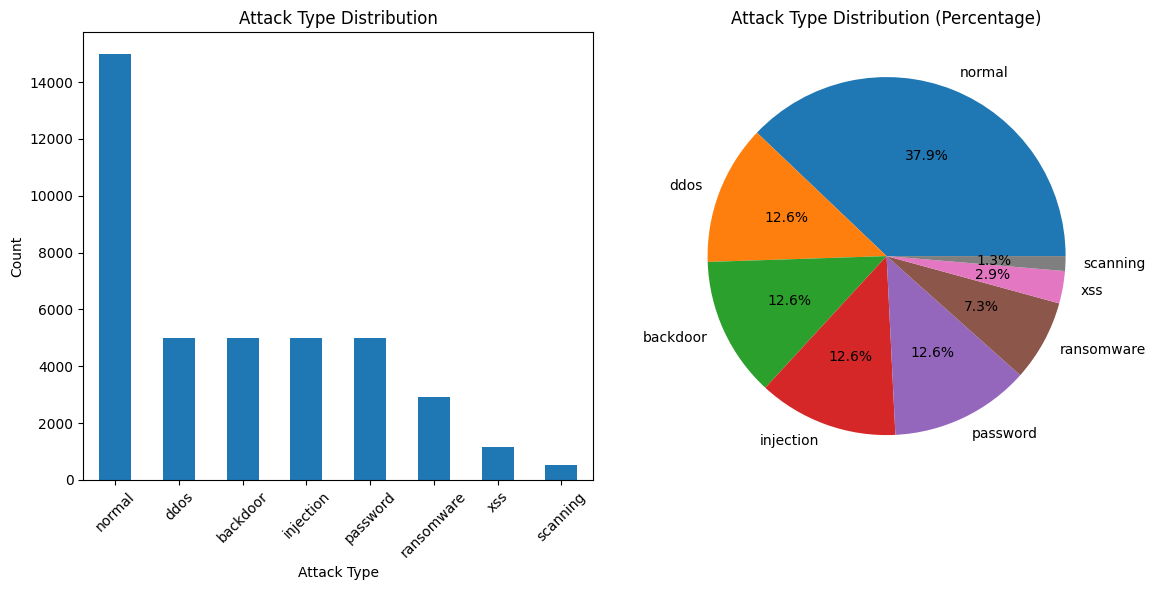

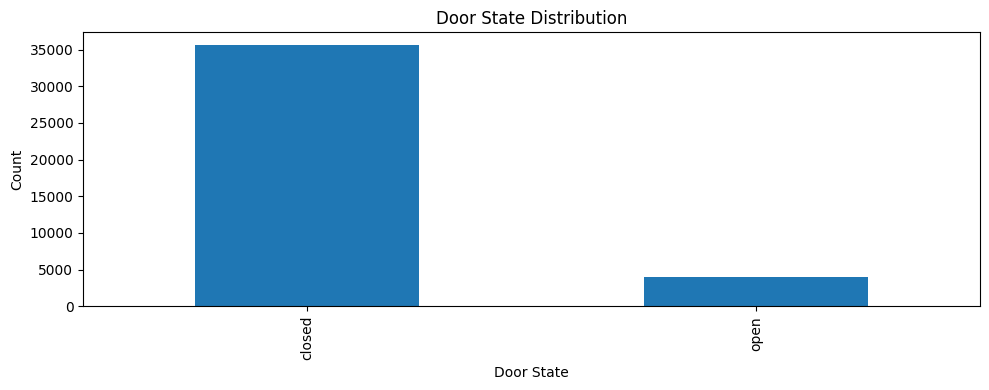

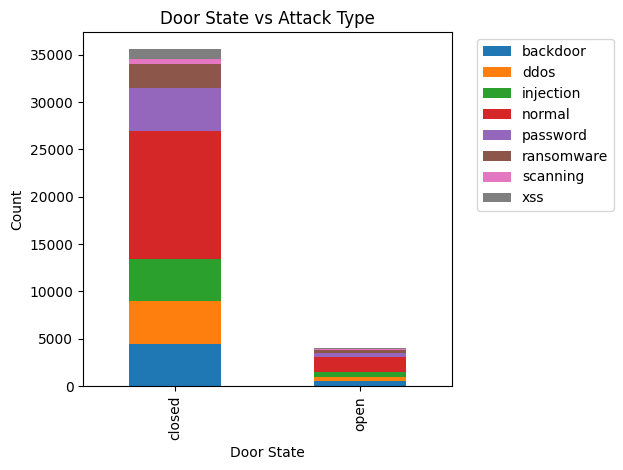

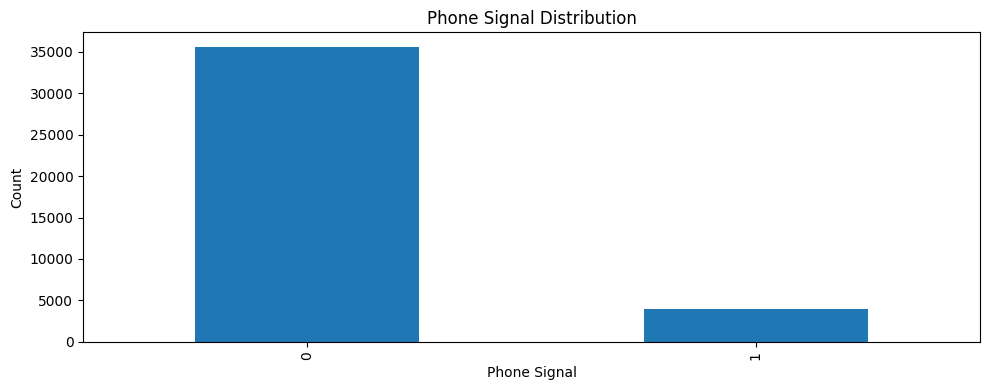

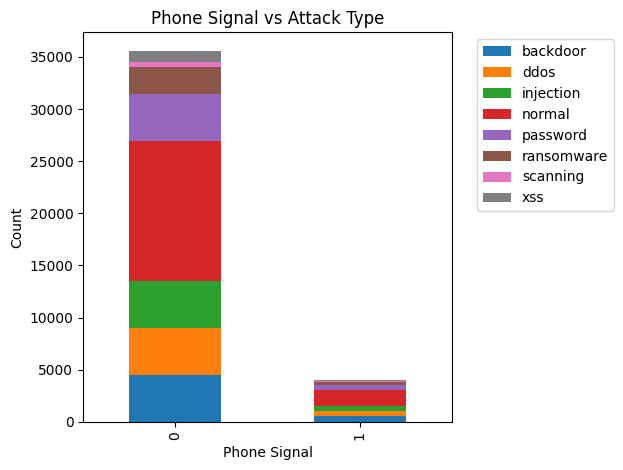

In [6]:
# ================================
# DATA EXPLORATION
# ================================

print("\n" + "="*50)
print("DATA EXPLORATION")
print("="*50)

# Check data types
print("Data Types:")
print(df.dtypes)

# Check unique values in categorical columns
print(f"\nUnique door states: {df['door_state'].unique()}")
print(f"Unique phone signal values: {df['sphone_signal'].unique()}")
print(f"Attack type distribution:")
attack_distribution = df['type'].value_counts()
print(attack_distribution)

# Visualize attack type distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
df['type'].value_counts().plot(kind='bar', rot=45)
plt.title('Attack Type Distribution')
plt.xlabel('Attack Type')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
df['type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Attack Type Distribution (Percentage)')
plt.ylabel('')

plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'attack_type_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

# Door state distribution
plt.figure(figsize=(10, 4))
df['door_state'].value_counts().plot(kind='bar')
plt.title('Door State Distribution')
plt.xlabel('Door State')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'door_state_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

pd.crosstab(df['door_state'], df['type']).plot(kind='bar', stacked=True)
plt.title('Door State vs Attack Type')
plt.xlabel('Door State')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'door_state_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

# Phone signal distribution
plt.figure(figsize=(10, 4))
df['sphone_signal'].value_counts().plot(kind='bar')
plt.title('Phone Signal Distribution')
plt.xlabel('Phone Signal')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'phone_signal_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

pd.crosstab(df['sphone_signal'], df['type']).plot(kind='bar', stacked=True)
plt.title('Phone Signal vs Attack Type')
plt.xlabel('Phone Signal')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'phone_signal_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

In [7]:
# Implementasi Kalman Filter untuk sphone_signal
def apply_kalman_filter(signal_data):
    if hasattr(signal_data, 'values'):
        signal_array = signal_data.values
    else:
        signal_array = np.array(signal_data)
    observations = signal_array.reshape(-1, 1)
    kf = KalmanFilter(
        transition_matrices=np.array([[1, 1], [0, 1]]),
        observation_matrices=np.array([[1, 0]]),
        initial_state_mean=np.array([signal_array[0], 0]),
        initial_state_covariance=np.eye(2),
        observation_covariance=np.array([[1.0]]),
        transition_covariance=np.array([[0.1, 0], [0, 0.1]]),
        n_dim_state=2
    )
    kf_fitted = kf.em(observations, n_iter=10)
    state_means, _ = kf_fitted.smooth(observations)
    return state_means[:, 0]

In [8]:
df_filtered = df.copy()
# df_filtered['sphone_signal'] = apply_kalman_filter(df['sphone_signal'])

In [9]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39587 entries, 0 to 39586
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           39587 non-null  object
 1   time           39587 non-null  object
 2   door_state     39587 non-null  object
 3   sphone_signal  39587 non-null  int64 
 4   label          39587 non-null  int64 
 5   type           39587 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.8+ MB


In [10]:
# ================================
# FEATURE ENGINEERING
# ================================

print("\n" + "="*50)
print("FEATURE ENGINEERING")
print("="*50)

df_processed = df_filtered.copy()

# Gabung datetime dan ekstrak komponen
df_processed['datetime'] = pd.to_datetime(
    df_processed['date'].str.strip() + ' ' + df_processed['time'].str.strip(),
    format='%d-%b-%y %H:%M:%S', errors='coerce'
)
df_processed = df_processed.sort_values('datetime').reset_index(drop=True)

# Group ID per menit
df_processed['group_id'] = df_processed['datetime'].dt.floor('T')

# Waktu & waktu sin/cos
df_processed['hour']        = df_processed['datetime'].dt.hour
df_processed['minute']      = df_processed['datetime'].dt.minute
df_processed['second']      = df_processed['datetime'].dt.second
df_processed['day_of_week'] = df_processed['datetime'].dt.dayofweek
df_processed['is_weekend']  = (df_processed['day_of_week'] >= 5).astype(int)
df_processed['hour_sin']    = np.sin(2*np.pi*df_processed['hour']/24)
df_processed['hour_cos']    = np.cos(2*np.pi*df_processed['hour']/24)
df_processed['min_sin']     = np.sin(2*np.pi*df_processed['minute']/60)
df_processed['min_cos']     = np.cos(2*np.pi*df_processed['minute']/60)

# Bendera waktu
df_processed['is_business_hour'] = ((df_processed['hour'] >= 9) & (df_processed['hour'] <= 17)).astype(int)
df_processed['is_night'] = ((df_processed['hour'] >= 22) | (df_processed['hour'] <= 6)).astype(int)
df_processed['is_rush_hour'] = (
    ((df_processed['hour'] >= 7) & (df_processed['hour'] <= 9)) | 
    ((df_processed['hour'] >= 17) & (df_processed['hour'] <= 19))
).astype(int)

# Encode door state
le = LabelEncoder()
df_processed['door_state_encoded'] = le.fit_transform(df_processed['door_state'])

# Time diff antar baris
df_processed['time_diff'] = df_processed['datetime'].diff().dt.total_seconds().fillna(0)

# Rolling window stats (window=10)
win = 10
roll_groups = df_processed[['door_state_encoded','sphone_signal']].rolling(window=win, min_periods=1)

df_processed['door_roll_mean'] = roll_groups['door_state_encoded'].mean()
df_processed['door_roll_std']  = roll_groups['door_state_encoded'].std().fillna(0)
df_processed['phone_roll_mean'] = roll_groups['sphone_signal'].mean()
df_processed['phone_roll_std']  = roll_groups['sphone_signal'].std().fillna(0)

# Fitur tambahan: interaksi antar sensor
df_processed['door_phone_ratio'] = df_processed['door_roll_mean'] / (df_processed['phone_roll_mean'] + 1e-5)
df_processed['door_phone_diff']  = df_processed['door_roll_mean'] - df_processed['phone_roll_mean']

# Fitur tambahan: derivatif sinyal
df_processed['signal_diff'] = df_processed['sphone_signal'].diff().fillna(0)
df_processed['door_state_diff'] = df_processed['door_state_encoded'].diff().fillna(0)

# Fitur tambahan: total durasi dan jumlah event dalam group_id
df_processed['event_duration'] = df_processed.groupby('group_id')['time_diff'].transform('sum')
df_processed['event_count'] = df_processed.groupby('group_id')['time_diff'].transform('count')

# Domain‑spesifik: FFT dominant freq & entropy
def dominant_freq(arr, sr=1.0):
    yf = np.abs(rfft(arr))
    xf = rfftfreq(len(arr), d=1/sr)
    idx = np.argmax(yf[1:]) + 1
    return xf[idx]

df_processed['door_dom_freq'] = (
    df_processed['door_state_encoded']
      .rolling(window=win, min_periods=win)
      .apply(lambda x: dominant_freq(x.values), raw=False)
      .fillna(0)
)

df_processed['phone_dom_freq'] = (
    df_processed['sphone_signal']
      .rolling(window=win, min_periods=win)
      .apply(lambda x: dominant_freq(x.values), raw=False)
      .fillna(0)
)

def window_entropy(arr):
    p,_ = np.histogram(arr, bins=10, density=True)
    p = p[p>0]
    return entropy(p)

df_processed['door_entropy'] = (
    df_processed['door_state_encoded']
      .rolling(window=win, min_periods=win)
      .apply(lambda x: window_entropy(x.values), raw=False)
      .fillna(0)
)

df_processed['phone_entropy'] = (
    df_processed['sphone_signal']
      .rolling(window=win, min_periods=win)
      .apply(lambda x: window_entropy(x.values), raw=False)
      .fillna(0)
)

print("Feature engineering extended. Columns:")
print([c for c in df_processed.columns if c not in df_filtered.columns])



FEATURE ENGINEERING
Feature engineering extended. Columns:
['datetime', 'group_id', 'hour', 'minute', 'second', 'day_of_week', 'is_weekend', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos', 'is_business_hour', 'is_night', 'is_rush_hour', 'door_state_encoded', 'time_diff', 'door_roll_mean', 'door_roll_std', 'phone_roll_mean', 'phone_roll_std', 'door_phone_ratio', 'door_phone_diff', 'signal_diff', 'door_state_diff', 'event_duration', 'event_count', 'door_dom_freq', 'phone_dom_freq', 'door_entropy', 'phone_entropy']


In [11]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39587 entries, 0 to 39586
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                39587 non-null  object        
 1   time                39587 non-null  object        
 2   door_state          39587 non-null  object        
 3   sphone_signal       39587 non-null  int64         
 4   label               39587 non-null  int64         
 5   type                39587 non-null  object        
 6   datetime            39587 non-null  datetime64[ns]
 7   group_id            39587 non-null  datetime64[ns]
 8   hour                39587 non-null  int32         
 9   minute              39587 non-null  int32         
 10  second              39587 non-null  int32         
 11  day_of_week         39587 non-null  int32         
 12  is_weekend          39587 non-null  int32         
 13  hour_sin            39587 non-null  float64   

In [12]:
# ================================
# IDENTIFYING MISSING VALUES
# ================================

print("\n" + "="*50)
print("MISSING VALUES ANALYSIS")
print("="*50)

# Check for missing values
missing_values = df_processed.isnull().sum()
missing_percentage = (missing_values / len(df_processed)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
})

print("Missing values summary:")
print(missing_df[missing_df['Missing Count'] > 0])

# Visualize missing values if any
if missing_values.sum() > 0:
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_processed.isnull(), cbar=True, yticklabels=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.savefig(os.path.join(viz_dir, 'missing_values_heatmap.png'), dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No missing values found in the dataset!")


MISSING VALUES ANALYSIS
Missing values summary:
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []
No missing values found in the dataset!


In [13]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39587 entries, 0 to 39586
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                39587 non-null  object        
 1   time                39587 non-null  object        
 2   door_state          39587 non-null  object        
 3   sphone_signal       39587 non-null  int64         
 4   label               39587 non-null  int64         
 5   type                39587 non-null  object        
 6   datetime            39587 non-null  datetime64[ns]
 7   group_id            39587 non-null  datetime64[ns]
 8   hour                39587 non-null  int32         
 9   minute              39587 non-null  int32         
 10  second              39587 non-null  int32         
 11  day_of_week         39587 non-null  int32         
 12  is_weekend          39587 non-null  int32         
 13  hour_sin            39587 non-null  float64   

In [14]:
# ----- STEP 1: Siapkan data -----
X_all = df_processed.copy()
X_all.drop(['date', 'time', 'door_state', 'datetime', 'group_id', 'type', 'label'], axis=1, inplace=True)
y_all = df_processed['type'].copy()
groups_all = df_processed['group_id']

# ----- STEP 2: Fungsi bantu untuk menghitung distribusi label -----
def get_label_distribution(y):
    dist = y.value_counts(normalize=True).sort_index()
    return dist

# ----- STEP 3: Cari split dengan distribusi label terbaik -----
best_split = None
lowest_diff_score = float('inf')

n_trials = 10  # jumlah percobaan

for trial in range(n_trials):
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=trial)

    for train_idx, temp_idx in sgkf.split(X_all, y_all, groups=groups_all):
        # Split awal: Train (70%), Temp (30%)
        X_train = X_all.iloc[train_idx]
        y_train = y_all.iloc[train_idx]
        groups_train = groups_all.iloc[train_idx]

        X_temp = X_all.iloc[temp_idx]
        y_temp = y_all.iloc[temp_idx]
        groups_temp = groups_all.iloc[temp_idx]

        # Dari Temp, split lagi jadi val/test (masing-masing 15%)
        sgkf_inner = StratifiedGroupKFold(n_splits=2, shuffle=True, random_state=trial)

        for val_idx, test_idx in sgkf_inner.split(X_temp, y_temp, groups=groups_temp):
            X_val = X_temp.iloc[val_idx]
            y_val = y_temp.iloc[val_idx]

            X_test = X_temp.iloc[test_idx]
            y_test = y_temp.iloc[test_idx]

            # Hitung distribusi label dan perbedaannya
            dist_train = get_label_distribution(y_train)
            dist_val = get_label_distribution(y_val)
            dist_test = get_label_distribution(y_test)

            # Gabungkan dan hitung error
            labels_all = sorted(list(set(y_all)))
            dist_train = dist_train.reindex(labels_all, fill_value=0)
            dist_val = dist_val.reindex(labels_all, fill_value=0)
            dist_test = dist_test.reindex(labels_all, fill_value=0)

            diff_score = mean_squared_error(dist_train, dist_val) + mean_squared_error(dist_train, dist_test)

            if diff_score < lowest_diff_score:
                lowest_diff_score = diff_score
                best_split = {
                    "X_train": X_train, "y_train": y_train,
                    "X_val": X_val, "y_val": y_val,
                    "X_test": X_test, "y_test": y_test
                }

            break  # hanya ambil satu val/test split dari 2-fold
    print(f"Percobaan {trial+1} selesai. Skor distribusi: {lowest_diff_score:.5f}")

# ----- STEP 4: Ambil hasil split terbaik -----
X_train_best = best_split["X_train"]
y_train_best = best_split["y_train"]
X_val_best = best_split["X_val"]
y_val_best = best_split["y_val"]
X_test_best = best_split["X_test"]
y_test_best = best_split["y_test"]

# ----- STEP 5: Tampilkan distribusi label terbaik -----
print("\nDistribusi label terbaik:")
for name, y_part in zip(['Train', 'Val', 'Test'], [y_train_best, y_val_best, y_test_best]):
    print(f"\n{name}:\n", y_part.value_counts(normalize=True).sort_index().apply(lambda x: f"{x:.2%}"))

Percobaan 1 selesai. Skor distribusi: 0.00372
Percobaan 2 selesai. Skor distribusi: 0.00372
Percobaan 3 selesai. Skor distribusi: 0.00138
Percobaan 4 selesai. Skor distribusi: 0.00138
Percobaan 5 selesai. Skor distribusi: 0.00138
Percobaan 6 selesai. Skor distribusi: 0.00138
Percobaan 7 selesai. Skor distribusi: 0.00138
Percobaan 8 selesai. Skor distribusi: 0.00138
Percobaan 9 selesai. Skor distribusi: 0.00138
Percobaan 10 selesai. Skor distribusi: 0.00138

Distribusi label terbaik:

Train:
 type
backdoor      12.92%
ddos          13.23%
injection     12.36%
normal        36.66%
password      13.15%
ransomware     7.01%
scanning       1.44%
xss            3.22%
Name: proportion, dtype: object

Val:
 type
backdoor      12.15%
ddos          11.96%
injection     13.35%
normal        38.65%
password      12.08%
ransomware     7.77%
scanning       1.08%
xss            2.94%
Name: proportion, dtype: object

Test:
 type
backdoor      11.25%
ddos           9.54%
injection     13.64%
normal    

In [15]:
print("Train class distribution:\n", y_train_best.value_counts(normalize=True))
print("Validation class distribution:\n", y_val_best.value_counts(normalize=True))
print("Test class distribution:\n", y_test_best.value_counts(normalize=True))

Train class distribution:
 type
normal        0.366640
ddos          0.132305
password      0.131482
backdoor      0.129242
injection     0.123641
ransomware    0.070073
xss           0.032187
scanning      0.014430
Name: proportion, dtype: float64
Validation class distribution:
 type
normal        0.386481
injection     0.133537
backdoor      0.121526
password      0.120820
ddos          0.119642
ransomware    0.077720
xss           0.029439
scanning      0.010834
Name: proportion, dtype: float64
Test class distribution:
 type
normal        0.447163
injection     0.136355
backdoor      0.112492
password      0.099459
ddos          0.095448
ransomware    0.089232
xss           0.010828
scanning      0.009023
Name: proportion, dtype: float64


In [16]:
def show_label_distribution(y_train, y_val, y_test, label_name='type'):
    # Buat dataframe dari label
    dist_df = pd.DataFrame({
        'train': y_train.value_counts(normalize=False),
        'val': y_val.value_counts(normalize=False),
        'test': y_test.value_counts(normalize=False)
    }).fillna(0).astype(int)

    dist_df_percent = pd.DataFrame({
        'train': y_train.value_counts(normalize=True) * 100,
        'val': y_val.value_counts(normalize=True) * 100,
        'test': y_test.value_counts(normalize=True) * 100
    }).fillna(0).round(2)

    # Tampilkan distribusi dalam bentuk tabel
    print("Distribusi Label (Jumlah):\n", dist_df)
    print("\nDistribusi Label (Persentase):\n", dist_df_percent)

    # Plot jumlah label
    dist_df.plot(kind='bar', figsize=(10, 6), colormap='viridis')
    plt.title(f'Distribusi Label {label_name.upper()} - Jumlah')
    plt.xlabel('Label')
    plt.ylabel('Jumlah')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # Plot persentase label
    dist_df_percent.plot(kind='bar', figsize=(10, 6), colormap='Set2')
    plt.title(f'Distribusi Label {label_name.upper()} - Persentase')
    plt.xlabel('Label')
    plt.ylabel('Persentase (%)')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

Distribusi Label (Jumlah):
             train   val  test
type                         
backdoor     3923   516   561
ddos         4016   508   476
injection    3753   567   680
normal      11129  1641  2230
password     3991   513   496
ransomware   2127   330   445
scanning      438    46    45
xss           977   125    54

Distribusi Label (Persentase):
             train    val   test
type                           
backdoor    12.92  12.15  11.25
ddos        13.23  11.96   9.54
injection   12.36  13.35  13.64
normal      36.66  38.65  44.72
password    13.15  12.08   9.95
ransomware   7.01   7.77   8.92
scanning     1.44   1.08   0.90
xss          3.22   2.94   1.08


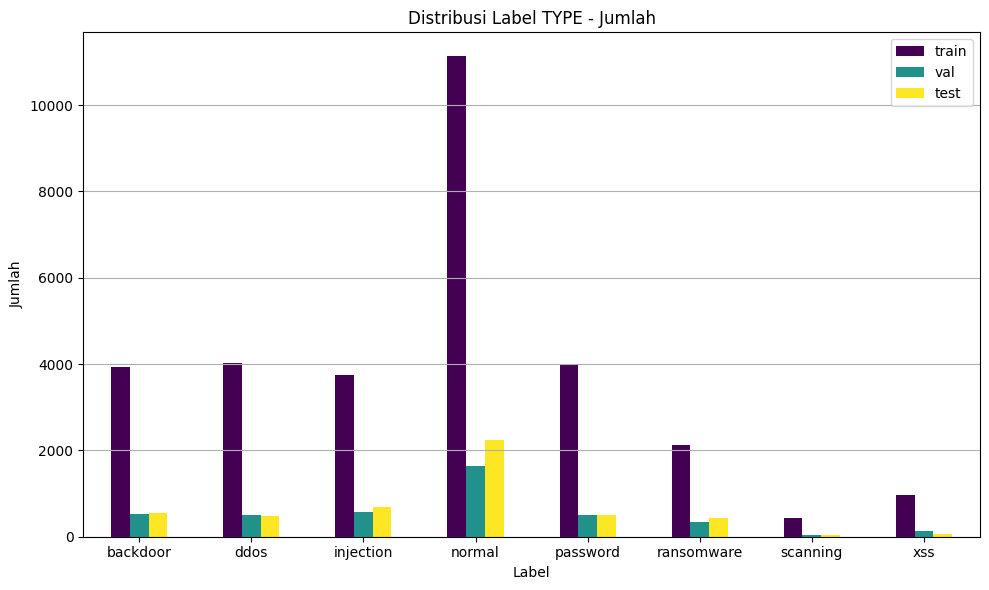

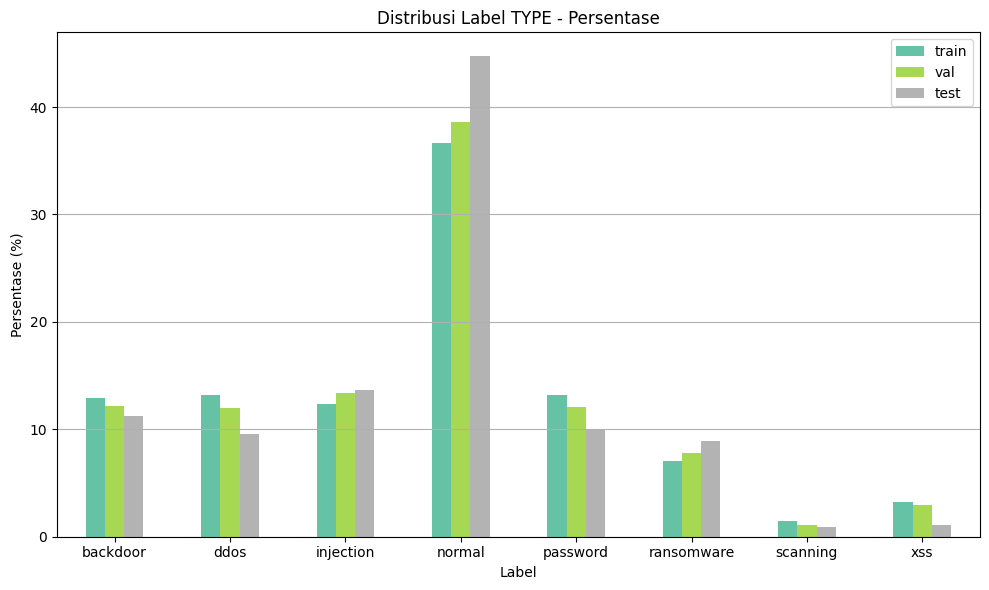

In [33]:
show_label_distribution(y_train_best, y_val_best, y_test_best, label_name='type')

In [17]:
# ================================
# SIMPLE IMPUTER AND MINMAX SCALER
# ================================

print("\n" + "="*50)
print("DATA PREPROCESSING - IMPUTATION AND SCALING")
print("="*50)

# Handle any remaining missing values with SimpleImputer
# imputer = SimpleImputer(strategy='median')
# X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# print(f"Features shape after imputation: {X_imputed.shape}")

# Apply MinMax Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_best)
X_val_scaled = scaler.transform(X_val_best)
X_test_scaled = scaler.transform(X_test_best)

print("Data scaling completed!")
print(f"Scaled features train shape: {X_train_scaled.shape}")
print(f"Scaled features val shape: {X_val_scaled.shape}")
print(f"Scaled features test shape: {X_test_scaled.shape}")

# Save preprocessors
# with open(os.path.join(artifacts_dir, 'imputer.pkl'), 'wb') as f:
#     pickle.dump(imputer, f)

with open(os.path.join(artifacts_dir, 'minmax.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

# print(f"Imputer saved to {artifacts_dir}/imputer.pkl")
print(f"Scaler saved to {artifacts_dir}/minmax.pkl")

# Encode target labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_best)
y_val_encoded = le.transform(y_val_best)
y_test_encoded = le.transform(y_test_best)

# Save target label encoder
with open(os.path.join(artifacts_dir, 'label_encoder_target.pkl'), 'wb') as f:
    pickle.dump(le, f)

print(f"Target classes: {le.classes_}")
print(f"Target train shape: {y_train_encoded.shape}")
print(f"Target val shape: {y_val_encoded.shape}")
print(f"Target test shape: {y_test_encoded.shape}")
print(f"Target label encoder saved to {artifacts_dir}/label_encoder_target.pkl")


DATA PREPROCESSING - IMPUTATION AND SCALING
Data scaling completed!
Scaled features train shape: (30354, 29)
Scaled features val shape: (4246, 29)
Scaled features test shape: (4987, 29)
Scaler saved to artifacts/minmax.pkl
Target classes: ['backdoor' 'ddos' 'injection' 'normal' 'password' 'ransomware' 'scanning'
 'xss']
Target train shape: (30354,)
Target val shape: (4246,)
Target test shape: (4987,)
Target label encoder saved to artifacts/label_encoder_target.pkl


In [18]:
y_train_cat = to_categorical(y_train_encoded)
y_val_cat = to_categorical(y_val_encoded)
y_test_cat = to_categorical(y_test_encoded)

In [19]:
print(X_train_scaled.shape)
print('\n',X_train_scaled[:5])
print('\n',X_val_scaled.shape)
print('\n',X_val_scaled[:5])
print('\n',X_test_scaled.shape)
print('\n',X_test_scaled[:5])
print('\n',y_train_encoded.shape)
print('\n',y_train_encoded[:10])
print('\n',y_val_encoded.shape)
print('\n',y_val_encoded[:10])
print('\n',y_test_encoded.shape)
print('\n',y_test_encoded[:10])
print('\n',y_train_cat.shape)
print('\n',y_train_cat[:10])
print('\n',y_val_cat.shape)
print('\n',y_val_cat[:10])
print('\n',y_test_cat.shape)
print('\n',y_test_cat[:10])

(30354, 29)

 [[0.00000000e+00 4.50000000e-01 7.11864407e-01 0.00000000e+00
  1.00000000e+00 1.00000000e+00 5.08666190e-01 0.00000000e+00
  2.44717419e-02 3.45491503e-01 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 5.33959561e-07 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 5.00000000e-01 5.00000000e-01 1.97562506e-05
  4.53998907e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 4.50000000e-01 7.11864407e-01 0.00000000e+00
  1.00000000e+00 1.00000000e+00 5.08666190e-01 0.00000000e+00
  2.44717419e-02 3.45491503e-01 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 5.00000000e-01 5.00000000e-01 1.97562506e-05
  4.53998907e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 4.50000000e-01 7.11864407e-01 0.00000000e+00
  1.00000000e+00 1.0

In [20]:
train_labels = np.argmax(y_train_cat, axis=1)
class_counts = Counter(train_labels)
total_samples = sum(class_counts.values())
minority_classes = [cls for cls, count in class_counts.items() if count / total_samples < 0.1]
print("Minority classes:", minority_classes)

Minority classes: [6, 7, 5]


In [22]:
# ================================
# SELEKSI FITUR GA
# ================================

# ========================================
# =========== PARAMETER & INPUT ==========
# ========================================
POP_SIZE = 20
N_GENERATIONS = 15
MUTATION_RATE = 0.2
TOURNAMENT_SIZE = 3
FEATURE_COUNT = X_train_scaled.shape[1]
N_CLASSES = y_train_cat.shape[1]

y_train_labels = np.argmax(y_train_cat, axis=1)
y_val_labels = np.argmax(y_val_cat, axis=1)

# =============================
# === CLASS WEIGHT OTOMATIS ===
# =============================
class_weight_values = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights = {i: w for i, w in enumerate(class_weight_values)}
print("Class weights:", class_weights)

# ========================================
# ========== MODEL LSTM SEDERHANA ========
# ========================================
def create_lstm_model(input_shape, n_classes):
    model = Sequential()
    model.add(LSTM(64, return_sequences=False, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])
    return model

# ========================
# === FITNESS FUNCTION ===
# ========================
def fitness(individual):
    if sum(individual) == 0:
        return 0.0,

    selected_features = [i for i, bit in enumerate(individual) if bit == 1]

    # Subset data
    X_train_sub = X_train_scaled[:, selected_features]
    X_val_sub = X_val_scaled[:, selected_features]

    # Reshape untuk LSTM
    X_train_sub = X_train_sub.reshape((X_train_sub.shape[0], 1, X_train_sub.shape[1]))
    X_val_sub = X_val_sub.reshape((X_val_sub.shape[0], 1, X_val_sub.shape[1]))

    # Buat model dan latih
    model = create_lstm_model(input_shape=(1, len(selected_features)), n_classes=N_CLASSES)
    model.fit(X_train_sub, y_train_cat, epochs=3, batch_size=64, verbose=0, class_weight=class_weights)

    # Evaluasi
    y_pred = np.argmax(model.predict(X_val_sub, verbose=0), axis=1)

    # Hitung F1 Macro dengan bobot kelas
    f1_per_class = f1_score(y_val_labels, y_pred, average=None)
    weights = np.array([class_weights.get(i, 1.0) for i in range(len(f1_per_class))])
    weighted_f1 = np.average(f1_per_class, weights=weights)

    return weighted_f1,

# ===========================
# === TOOLS UNTUK GA ===
# ===========================
def init_population():
    return [np.random.randint(0, 2, FEATURE_COUNT).tolist() for _ in range(POP_SIZE)]

def tournament_selection(pop, fitnesses):
    selected = random.sample(list(zip(pop, fitnesses)), TOURNAMENT_SIZE)
    selected = sorted(selected, key=lambda x: x[1][0], reverse=True)
    return selected[0][0]

def crossover(parent1, parent2):
    point = random.randint(1, FEATURE_COUNT - 1)
    return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

def mutate(individual):
    for i in range(FEATURE_COUNT):
        if random.random() < MUTATION_RATE:
            individual[i] = 1 - individual[i]

# ==========================
# === MAIN LOOP GA ===
# ==========================
population = init_population()
fitnesses = [fitness(ind) for ind in population]

for gen in range(N_GENERATIONS):
    print(f'\nGeneration {gen + 1}/{N_GENERATIONS}')
    f1s = [fit[0] for fit in fitnesses]
    print(f' Best fitness: {max(f1s):.4f} | Avg fitness: {np.mean(f1s):.4f}')

    new_population = []
    while len(new_population) < POP_SIZE:
        p1 = tournament_selection(population, fitnesses)
        p2 = tournament_selection(population, fitnesses)
        c1, c2 = crossover(p1, p2)
        mutate(c1)
        mutate(c2)
        new_population.extend([c1, c2])

    population = new_population[:POP_SIZE]
    fitnesses = [fitness(ind) for ind in population]

# ===========================
# === OUTPUT AKHIR GA ===
# ===========================
f1s = [fit[0] for fit in fitnesses]
best_idx = np.argmax(f1s)
best_individual = population[best_idx]
selected_features = [i for i, bit in enumerate(best_individual) if bit == 1]

print("\n=== HASIL SELEKSI FITUR GA DENGAN CLASS WEIGHT ===")
print("Indeks Fitur Terpilih:", selected_features)
print("Jumlah Fitur Terpilih:", len(selected_features))
print("Best Fitness (Weighted F1 Macro): {:.4f}".format(f1s[best_idx]))

Class weights: {0: 0.9671807290339026, 1: 0.9447833665338645, 2: 1.0109912070343725, 3: 0.34093359690897657, 4: 0.9507015785517414, 5: 1.7838504936530324, 6: 8.662671232876713, 7: 3.883572159672467}

Generation 1/15
 Best fitness: 0.9032 | Avg fitness: 0.7086

Generation 2/15
 Best fitness: 0.9155 | Avg fitness: 0.8030

Generation 3/15
 Best fitness: 0.9032 | Avg fitness: 0.8221

Generation 4/15
 Best fitness: 0.9032 | Avg fitness: 0.8551

Generation 5/15
 Best fitness: 0.9570 | Avg fitness: 0.8491

Generation 6/15
 Best fitness: 0.9687 | Avg fitness: 0.8466

Generation 7/15
 Best fitness: 0.9032 | Avg fitness: 0.7900

Generation 8/15
 Best fitness: 0.9032 | Avg fitness: 0.8587

Generation 9/15
 Best fitness: 0.9460 | Avg fitness: 0.8887

Generation 10/15
 Best fitness: 0.9032 | Avg fitness: 0.8802

Generation 11/15
 Best fitness: 0.9994 | Avg fitness: 0.8644

Generation 12/15
 Best fitness: 0.9400 | Avg fitness: 0.7951

Generation 13/15
 Best fitness: 1.0000 | Avg fitness: 0.8063

Gen

In [23]:
feature_names = X_all.columns.tolist()

selected_feature_names = [feature_names[i] for i in selected_features]
print("Selected Feature Names:", selected_feature_names)

Selected Feature Names: ['sphone_signal', 'minute', 'day_of_week', 'hour_cos', 'min_cos', 'is_rush_hour', 'time_diff', 'door_roll_mean', 'door_roll_std', 'phone_roll_mean', 'phone_roll_std', 'door_phone_diff', 'signal_diff', 'door_state_diff', 'door_dom_freq', 'phone_dom_freq', 'phone_entropy']


In [35]:
X_train_selected = pd.DataFrame(X_train_scaled[:, selected_features], columns=[feature_names[i] for i in selected_features])
print(X_train_selected.shape)
print(X_train_selected.info())
print(X_train_selected.head())

(30354, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30354 entries, 0 to 30353
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sphone_signal    30354 non-null  float64
 1   minute           30354 non-null  float64
 2   day_of_week      30354 non-null  float64
 3   hour_cos         30354 non-null  float64
 4   min_cos          30354 non-null  float64
 5   is_rush_hour     30354 non-null  float64
 6   time_diff        30354 non-null  float64
 7   door_roll_mean   30354 non-null  float64
 8   door_roll_std    30354 non-null  float64
 9   phone_roll_mean  30354 non-null  float64
 10  phone_roll_std   30354 non-null  float64
 11  door_phone_diff  30354 non-null  float64
 12  signal_diff      30354 non-null  float64
 13  door_state_diff  30354 non-null  float64
 14  door_dom_freq    30354 non-null  float64
 15  phone_dom_freq   30354 non-null  float64
 16  phone_entropy    30354 non-null  float64
dtype

In [36]:
X_val_selected = pd.DataFrame(X_val_scaled[:, selected_features], columns=[feature_names[i] for i in selected_features])
print(X_val_selected.shape)
print(X_val_selected.info())

(4246, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4246 entries, 0 to 4245
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sphone_signal    4246 non-null   float64
 1   minute           4246 non-null   float64
 2   day_of_week      4246 non-null   float64
 3   hour_cos         4246 non-null   float64
 4   min_cos          4246 non-null   float64
 5   is_rush_hour     4246 non-null   float64
 6   time_diff        4246 non-null   float64
 7   door_roll_mean   4246 non-null   float64
 8   door_roll_std    4246 non-null   float64
 9   phone_roll_mean  4246 non-null   float64
 10  phone_roll_std   4246 non-null   float64
 11  door_phone_diff  4246 non-null   float64
 12  signal_diff      4246 non-null   float64
 13  door_state_diff  4246 non-null   float64
 14  door_dom_freq    4246 non-null   float64
 15  phone_dom_freq   4246 non-null   float64
 16  phone_entropy    4246 non-null   float64
dtypes: 

In [37]:
X_test_selected = pd.DataFrame(X_test_scaled[:, selected_features], columns=[feature_names[i] for i in selected_features])
print(X_test_selected.shape)
print(X_test_selected.info())

(4987, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4987 entries, 0 to 4986
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sphone_signal    4987 non-null   float64
 1   minute           4987 non-null   float64
 2   day_of_week      4987 non-null   float64
 3   hour_cos         4987 non-null   float64
 4   min_cos          4987 non-null   float64
 5   is_rush_hour     4987 non-null   float64
 6   time_diff        4987 non-null   float64
 7   door_roll_mean   4987 non-null   float64
 8   door_roll_std    4987 non-null   float64
 9   phone_roll_mean  4987 non-null   float64
 10  phone_roll_std   4987 non-null   float64
 11  door_phone_diff  4987 non-null   float64
 12  signal_diff      4987 non-null   float64
 13  door_state_diff  4987 non-null   float64
 14  door_dom_freq    4987 non-null   float64
 15  phone_dom_freq   4987 non-null   float64
 16  phone_entropy    4987 non-null   float64
dtypes: 

In [41]:
zero_std_cols = X_train_selected.loc[:, X_train_selected.std() == 0].columns
print("Kolom dengan standar deviasi 0:", zero_std_cols)

Kolom dengan standar deviasi 0: Index(['door_phone_diff'], dtype='object')



CORRELATION ANALYSIS


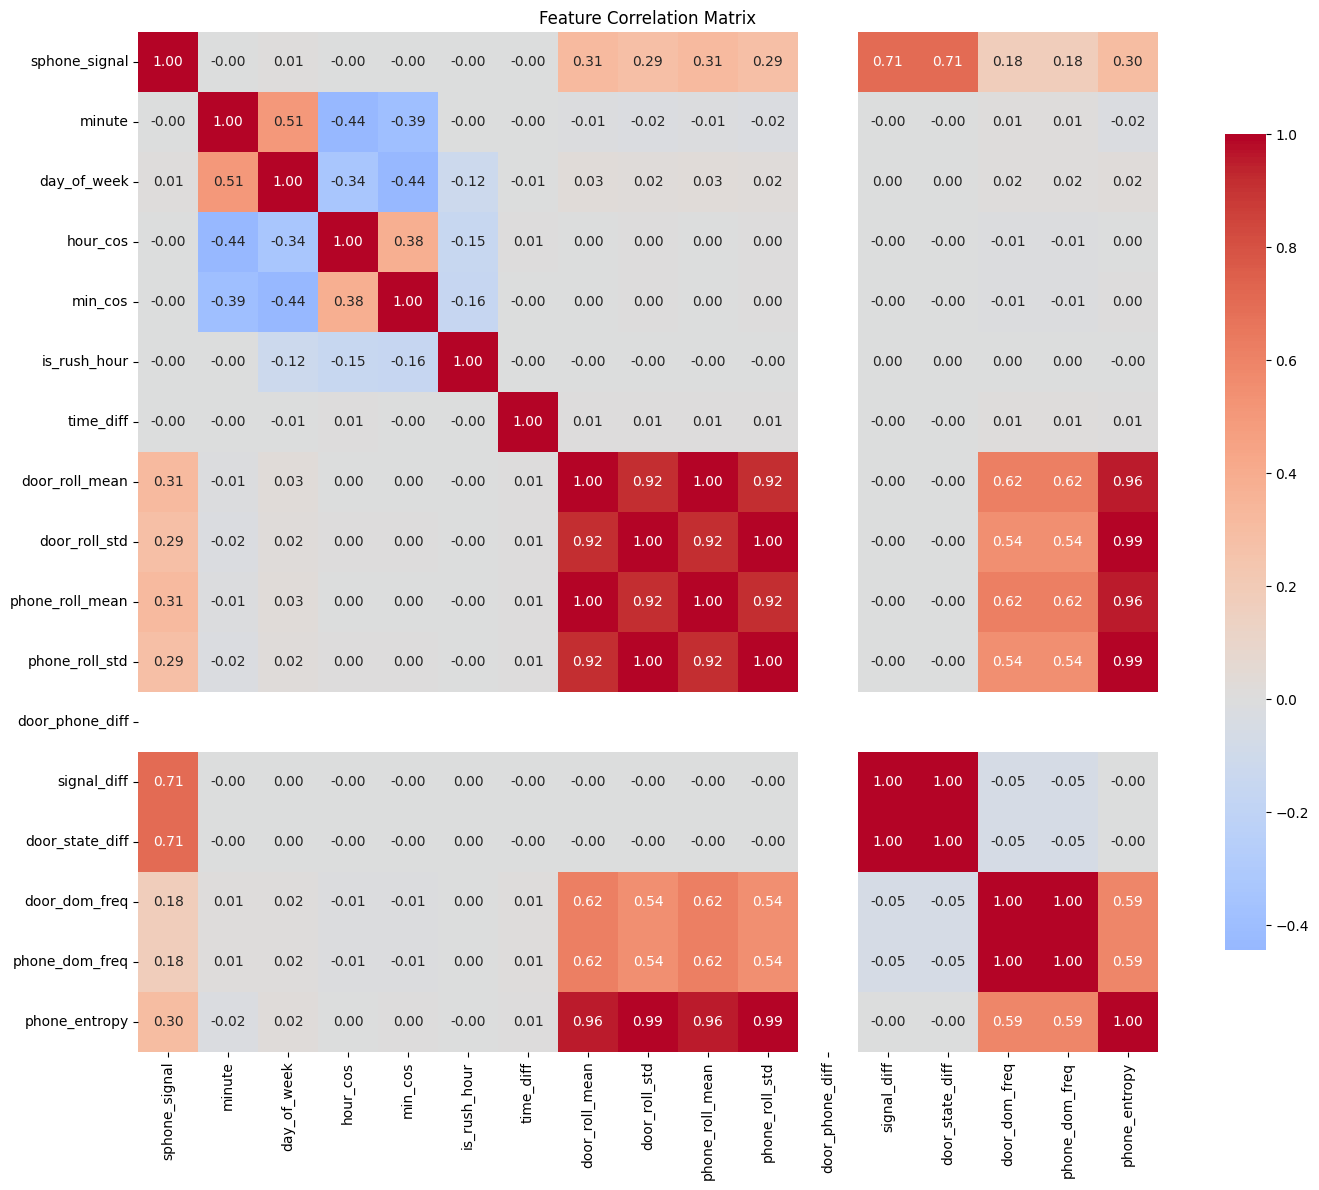

In [42]:
# ================================
# CORRELATION ANALYSIS
# ================================

print("\n" + "="*50)
print("CORRELATION ANALYSIS")
print("="*50)

# Calculate correlation matrix
correlation_matrix = X_train_selected.corr()

# Visualize correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'correlation_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

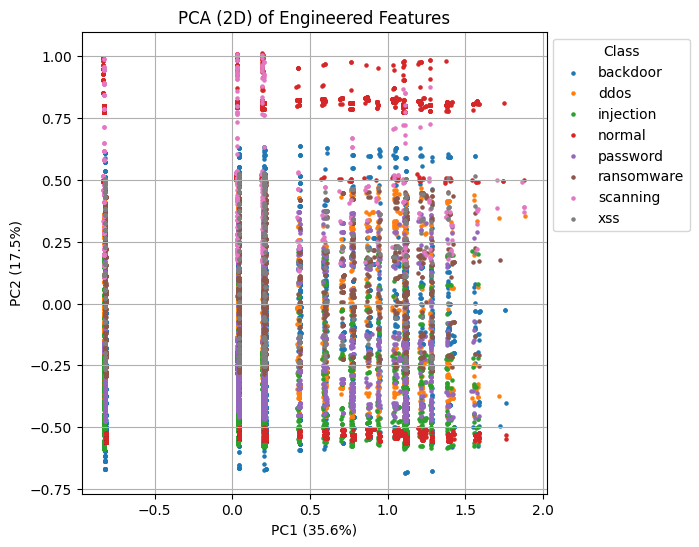

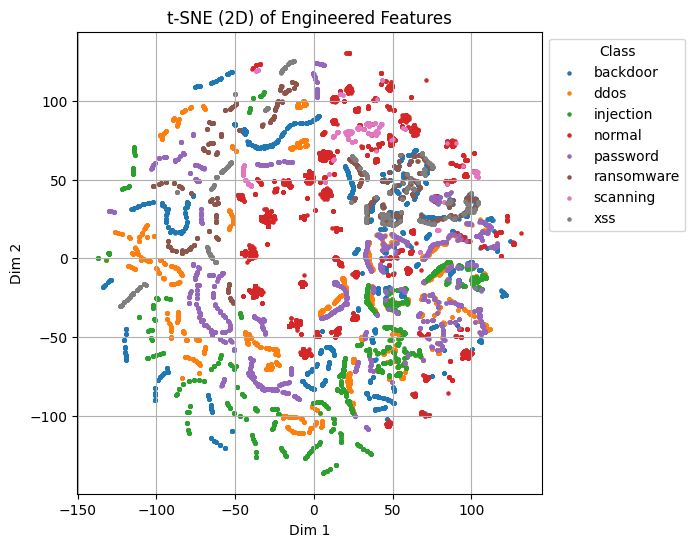

In [43]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_train_selected)

plt.figure(figsize=(6,6))
for cls in np.unique(y_train_best):
    idx = y_train_best == cls
    plt.scatter(X_pca[idx,0], X_pca[idx,1], s=5, label=str(cls))
plt.legend(title='Class', bbox_to_anchor=(1,1))
plt.title('PCA (2D) of Engineered Features')
plt.xlabel('PC1 (%.1f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC2 (%.1f%%)' % (pca.explained_variance_ratio_[1]*100))
plt.grid(True)
plt.savefig(os.path.join(viz_dir, 'PCA_engineering_feature.png'), dpi=300, bbox_inches='tight')
plt.show()

# 4) t-SNE → 2 dimensi (lebih lambat)
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_train_selected)  # pada seluruh dataset atau subset

plt.figure(figsize=(6,6))
for cls in np.unique(y_train_best):
    idx = y_train_best == cls
    plt.scatter(X_tsne[idx,0], X_tsne[idx,1], s=5, label=str(cls))
plt.legend(title='Class', bbox_to_anchor=(1,1))
plt.title('t-SNE (2D) of Engineered Features')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.grid(True)
plt.savefig(os.path.join(viz_dir, 'tSNE_2D_engineering_feature.png'), dpi=300, bbox_inches='tight')
plt.show()

In [44]:
tsne_3d = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42)
X_tsne_3d = tsne_3d.fit_transform(X_train_selected)

# 2) Buat DataFrame untuk Plotly
df_tsne = pd.DataFrame({
    'Dim1': X_tsne_3d[:, 0],
    'Dim2': X_tsne_3d[:, 1],
    'Dim3': X_tsne_3d[:, 2],
    'Class': y_train_best
})

# 3) Plot interaktif 3D
fig = px.scatter_3d(
    df_tsne,
    x='Dim1', y='Dim2', z='Dim3',
    color='Class',
    opacity=0.7,
    title='t-SNE (3D) of Engineered Features',
    width=900, height=700
)
fig.update_traces(marker=dict(size=4))
fig.update_layout(
    scene = dict(
        xaxis_title='Dim 1',
        yaxis_title='Dim 2',
        zaxis_title='Dim 3'
    ),
    legend_title='Class'
)

# 4) Simpan file HTML ke folder viz_dir
html_path = os.path.join(viz_dir, 'tsne_3d.html')
fig.write_html(html_path)

print(f"File HTML disimpan di: {html_path}")

# PCA ke dalam 3 dimensi
pca = PCA(n_components=3, random_state=42)
X_pca_3d = pca.fit_transform(X_train_selected)

# Buat DataFrame dari hasil PCA dan label
df_pca = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])
df_pca['label'] = y_train_best

# Visualisasi interaktif 3D menggunakan Plotly
fig = px.scatter_3d(
    df_pca, x='PC1', y='PC2', z='PC3',
    color='label',
    title='PCA (3D) of Engineered Features',
    labels={'label': 'Class'},
    opacity=0.7,
    width=800,
    height=600
)

# Simpan hasil visualisasi ke file HTML
output_html_path = os.path.join(viz_dir, 'PCA_3D.html')
fig.write_html(output_html_path)

File HTML disimpan di: visualization\tsne_3d.html


In [45]:
# Simpan ke file pickle
with open(os.path.join(artifacts_dir, 'data_train_preprocessing.pkl'), 'wb') as f:
    pickle.dump((X_train_selected, y_train_cat), f)
    
# Simpan ke file CSV
df_final = pd.DataFrame(X_train_selected)
df_final['type'] = np.array(y_train_encoded)

csv_path = os.path.join(artifacts_dir, 'data_train_preprocessing.csv')
df_final.to_csv(csv_path, index=False)

In [46]:
# Simpan ke file pickle
with open(os.path.join(artifacts_dir, 'data_val_preprocessing.pkl'), 'wb') as f:
    pickle.dump((X_val_selected, y_val_cat), f)
    
# Simpan ke file CSV
df_final = pd.DataFrame(X_val_selected)
df_final['type'] = np.array(y_val_encoded)

csv_path = os.path.join(artifacts_dir, 'data_val_preprocessing.csv')
df_final.to_csv(csv_path, index=False)

In [47]:
# Simpan ke file pickle
with open(os.path.join(artifacts_dir, 'data_test_preprocessing.pkl'), 'wb') as f:
    pickle.dump((X_test_selected, y_test_cat), f)
    
# Simpan ke file CSV
df_final = pd.DataFrame(X_test_selected)
df_final['type'] = np.array(y_test_encoded)

csv_path = os.path.join(artifacts_dir, 'data_test_preprocessing.csv')
df_final.to_csv(csv_path, index=False)